# Shallow DMAE

This notebook is an example on how to use the tensorflow implementation of the Dissimilarity Mixture Autoencoder (DMAE).
We will show some examples on synthetic data.

In [1]:
# Required libraries
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib import colors
plt.style.use("ggplot")
%matplotlib inline

# Path of the DMAE library
import sys
# sys.path.append("/tf/home/repositorios/DMAE/") # how to use the code in other location
sys.path.append("../../")
import DMAE

# Setting random seed
np.random.seed(0)
tf.random.set_seed(0)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# Imporing some helper functions to visualize and understand the results
import vis_utils

## Isotropicly Distributed Blobs

First, we're going to generate isotropic Gaussian blobs with the following parameters:

Text(0.5, 1.0, 'Generated Data')

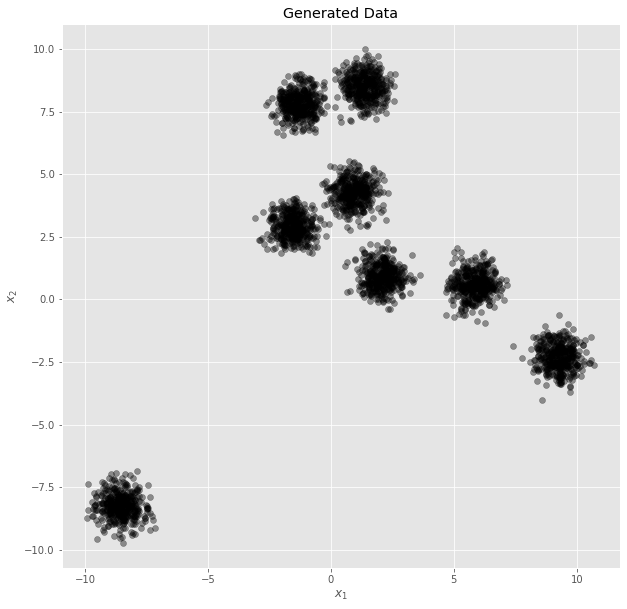

In [2]:
# Number of samples to generate
n_samples = 3200
X, _ = make_blobs(n_samples=n_samples, centers=8, cluster_std=0.5)
X = np.float32(X)
# Visualizing the generated points
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c="k", alpha=0.4)
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.title("Generated Data")

Now, we define some hyperparameters:

In [3]:
# Number of clusters
n_clusters = 8
# Softmax inverse temperature parameter
alpha = 1000
# Training parameters
batch_size = 256
epochs = 100
lr = 1e-3

Please choose a dissimilarity:

In [4]:
import ipywidgets as widgets
from IPython.display import display
button = widgets.Dropdown(options=['Manhattan', 'Euclidean', 'Minkowski', 'Chebyshev', 'Cosine', 'Correlation'], value='Euclidean',
                          description='Dissimilarity:', disabled=False)
output = widgets.Output()
display(button, output)

dis_name = "Euclidean"
def on_change(val):
    if val['type'] == 'change' and val['name'] == 'value':
        global dis_name
        dis_name = val["new"]
button.observe(on_change)

Dropdown(description='Dissimilarity:', index=1, options=('Manhattan', 'Euclidean', 'Minkowski', 'Chebyshev', '…

Output()

Specify the order $p$ (only possible if you are using the Minkowski dissimilarity):

In [5]:
if dis_name == "Minkowski":
    button = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1, description='Order:',
                                 disabled=False, continuous_update=True, orientation='horizontal', readout=True,
                                 readout_format='.1f')
    output = widgets.Output()
    display(button, output)
    p = 1
    def on_change(val):
        with output:
            if val['type'] == 'change' and val['name'] == 'value':
                global p
                p = val["new"]
    button.observe(on_change)

Let us define the dissimilarity and the loss according to the selected values:

In [6]:
print(f"Using dissimilarity [{dis_name}]")
if dis_name == "Manhattan":
    dis = DMAE.Dissimilarities.manhattan
    dmae_loss = DMAE.Losses.manhattan_loss
elif dis_name == "Euclidean":
    dis = DMAE.Dissimilarities.euclidean
    dmae_loss = DMAE.Losses.euclidean_loss
elif dis_name == "Minkowski":
    dis = lambda X, Y: DMAE.Dissimilarities.minkowsky(X, Y, p)
    dmae_loss = lambda X, Y: DMAE.Losses.minkowsky_loss(X, Y, p)
elif dis_name == "Chebyshev":
    dis = DMAE.Dissimilarities.chebyshev
    dmae_loss = DMAE.Losses.chebyshev_loss
elif dis_name == "Cosine":
    dis = DMAE.Dissimilarities.cosine
    dmae_loss = DMAE.Losses.cosine_loss
elif dis_name == "Correlation":
    dis = DMAE.Dissimilarities.correlation
    dmae_loss = DMAE.Losses.correlation_loss

Using dissimilarity [Euclidean]


Defining the shallow DMAE model:

In [7]:
inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoder(alpha=alpha, n_clusters=n_clusters,
                                                          initializers={"centers": DMAE.Initializers.InitPlusPlus(X, n_clusters, dis, 100),
                                                                        "mixers": tf.keras.initializers.Constant(1.0)},
                                                          trainable = {"centers": True, "mixers": True},
                                                          dissimilarity=dis)(inp)
# DMAE model
model = tf.keras.Model(inputs=[inp], outputs=theta_tilde)
model.compile(loss=dmae_loss, optimizer=tf.optimizers.Adam(lr=lr))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dissimilarity_mixture_autoen (None, 2)                 24        
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


Training the model:

In [9]:
model.fit(X, X, epochs=epochs, batch_size=batch_size)

Epoch 1/100
13/13 [==============================] - 1s 66ms/step - loss: 1.0225
Epoch 2/100
13/13 [==============================] - 1s 61ms/step - loss: 1.0095
Epoch 3/100
13/13 [==============================] - 1s 68ms/step - loss: 0.9993
Epoch 4/100
13/13 [==============================] - 1s 67ms/step - loss: 0.9894
Epoch 5/100
13/13 [==============================] - 1s 71ms/step - loss: 0.9795
Epoch 6/100
13/13 [==============================] - 1s 67ms/step - loss: 0.9689
Epoch 7/100
13/13 [==============================] - 1s 66ms/step - loss: 0.9597
Epoch 8/100
13/13 [==============================] - 1s 70ms/step - loss: 0.9503
Epoch 9/100
13/13 [==============================] - 1s 73ms/step - loss: 0.9412
Epoch 10/100
13/13 [==============================] - 1s 82ms/step - loss: 0.9324
Epoch 11/100
13/13 [==============================] - 1s 62ms/step - loss: 0.9231
Epoch 12/100
13/13 [==============================] - 1s 67ms/step - loss: 0.9169
Epoch 13/100
13/13 [=====

To visualize the results, we define an auxiliar model for the encoder:

In [10]:
inp = tf.keras.layers.Input(shape=(2,))
assigns = DMAE.Layers.DissimilarityMixtureEncoder(alpha=0.1, n_clusters=n_clusters,
                                                  dissimilarity=dis,
                                                  trainable={"centers": False, "mixers": False})(inp)
DMAE_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
DMAE_encoder.layers[-1].set_weights(model.layers[1].get_weights())

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Let's see the Voronoi regions

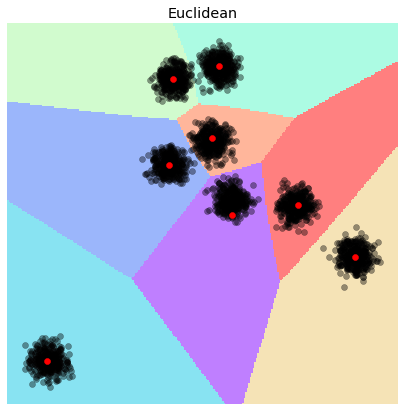

In [11]:
fig, ax = vis_utils.visualize_regions(DMAE_encoder, dis_name, X, (7, 7), batch_size)

We can visualize the mixed distribution:

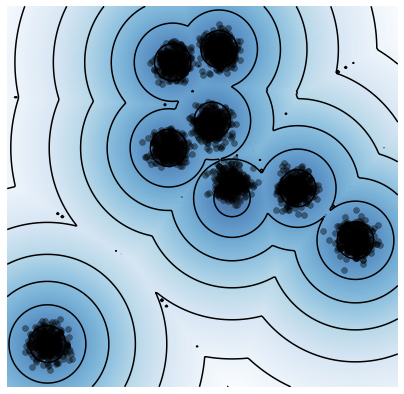

In [12]:
fig, ax = vis_utils.visualize_distribution(model, dmae_loss, 0.1, X, figsize=(7, 7))

The posterior cluster distributions:

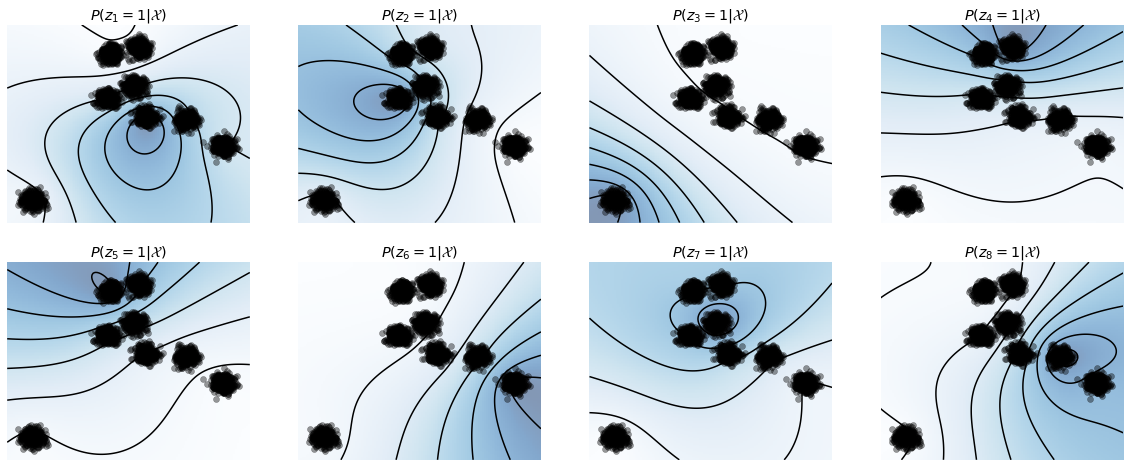

In [13]:
fig, ax = vis_utils.visualize_probas(DMAE_encoder, X, n_clusters, rows=2, cols=4, figsize=(20, 8))

## Painwheel Data

Now, we'll generate the Painwheel synthetic data that was used in: 

M. J. Johnson, D. K. Duvenaud, A. Wiltschko, R. P. Adams, and S. R. Datta, “Composing
368 graphical models with neural networks for structured representations and fast inference,” in
369 Advances in neural information processing systems, pp. 2946–2954, 2016.

In [14]:
def make_painwheel(rad_std, tan_std, n_groups, N, rate):
    """
    Generates the painwheel data, adapted from: https://github.com/mattjj/svae
    Arguments:
        rad_std: float
            Standard deviation for the angles.
        tan_std: float
            Tangential standard deviation.
        n_groups: int
            Number of groups to be generated.
        N: int
            Total number of samples.
        rate: float
            Controls the magnitude of the rotations.
        
    Returns:
        D: array-like, shape=(batch_size, n_clusters)
            Matrix of paiwise dissimilarities between the batch and the cluster's parameters.
    """
    np.random.seed(0)
    rads = np.linspace(0, 2*np.pi, n_groups, endpoint=False)
    samples = np.random.randn(N, 2)*np.array([rad_std, tan_std])
    samples[:,0] += 1
    labels = np.repeat(np.arange(n_groups), N//n_groups)

    angles = rads[labels]+rate*np.exp(samples[:,0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1, 2, 2))

    return np.random.permutation(np.einsum('ti,tij->tj', samples, rotations))

Text(0.5, 1.0, 'Generated Data')

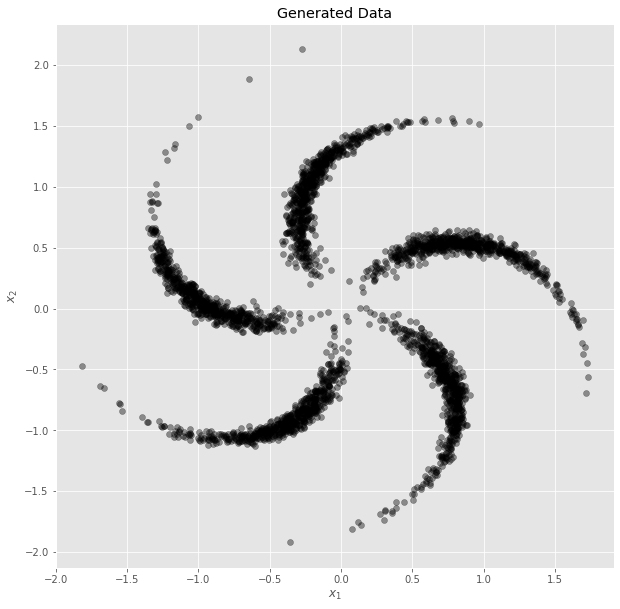

In [15]:
X = make_painwheel(0.3, 0.05, 5, 3200, 0.25)
# Visualizing the generated points
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], alpha=0.4, c="k")
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.title("Generated Data")

Now, we define some hyperparameters:

In [16]:
# Number of prototype vectors
n_clusters = 5
# Softmax inverse temperature parameter
alpha = 1000
# Training parameters
batch_size = 32
epochs = 40
lr = 1e-4

We'll solve this problem using the Mahalanobis distance (includes the covariances):

In [17]:
dis = DMAE.Dissimilarities.mahalanobis
dmae_loss = DMAE.Losses.mahalanobis_loss
dis_name = "Mahalanobis"

The model will be pretrained using K-means:

In [18]:
pretrainer = KMeans(n_clusters=n_clusters).fit(X)

Now, we can define a DMAE model for this dissimilarity:

In [19]:
inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoderCov(alpha=alpha, n_clusters=n_clusters,
                                                             initializers={"centers": DMAE.Initializers.InitKMeans(pretrainer),
                                                                           "cov": DMAE.Initializers.InitKMeansCov(pretrainer, X, n_clusters),
                                                                           "mixers": tf.keras.initializers.Constant(1.0)},
                                                             trainable = {"centers": True, "cov": True, "mixers": True},
                                                             dissimilarity=dis)(inp)
# DMAE model
model = tf.keras.Model(inputs=[inp], outputs=theta_tilde)
loss = dmae_loss(inp, *theta_tilde)
model.add_loss(loss)
model.compile(optimizer=tf.optimizers.Adam(lr=lr))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Training the model:

In [20]:
model.fit(X, epochs=epochs, batch_size=batch_size)

Epoch 1/40
100/100 [==============================] - 2s 20ms/step - loss: 1.8416
Epoch 2/40
100/100 [==============================] - 2s 19ms/step - loss: 1.8298
Epoch 3/40
100/100 [==============================] - 2s 17ms/step - loss: 1.8190
Epoch 4/40
100/100 [==============================] - 2s 17ms/step - loss: 1.8090
Epoch 5/40
100/100 [==============================] - 2s 19ms/step - loss: 1.7992
Epoch 6/40
100/100 [==============================] - 2s 19ms/step - loss: 1.7897
Epoch 7/40
100/100 [==============================] - 2s 19ms/step - loss: 1.7804
Epoch 8/40
100/100 [==============================] - 2s 17ms/step - loss: 1.7712
Epoch 9/40
100/100 [==============================] - 2s 17ms/step - loss: 1.7620
Epoch 10/40
100/100 [==============================] - 2s 17ms/step - loss: 1.7531
Epoch 11/40
100/100 [==============================] - 2s 17ms/step - loss: 1.7442
Epoch 12/40
100/100 [==============================] - 2s 18ms/step - loss: 1.7353
Epoch 13/40
1

To visualize the results, we define an auxiliar model for the encoder:

In [21]:
inp = tf.keras.layers.Input(shape=(2,))
assigns = DMAE.Layers.DissimilarityMixtureEncoderCov(alpha=0.1, n_clusters=n_clusters,
                                                     dissimilarity=dis,
                                                     trainable={"centers": False, "cov":False, "mixers": False})(inp)
DMAE_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
DMAE_encoder.layers[-1].set_weights(model.layers[1].get_weights())

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Let's see the Voronoi regions

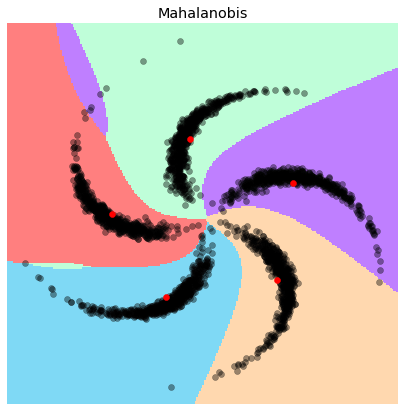

In [22]:
fig, ax = vis_utils.visualize_regions(DMAE_encoder, dis_name, X, (7, 7), batch_size)

We can visualize the mixed distribution:

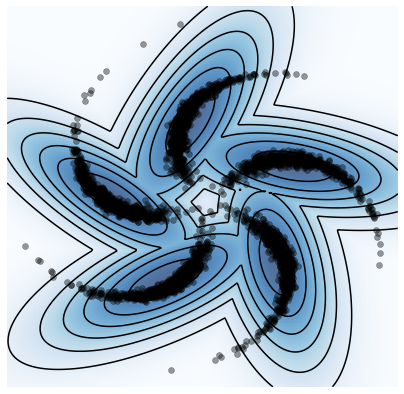

In [23]:
fig, ax = vis_utils.visualize_distribution(model, dmae_loss, 0.1, X, figsize=(7, 7), cov=True)

The posterior distributions:

(0.0, 1.0, 0.0, 1.0)

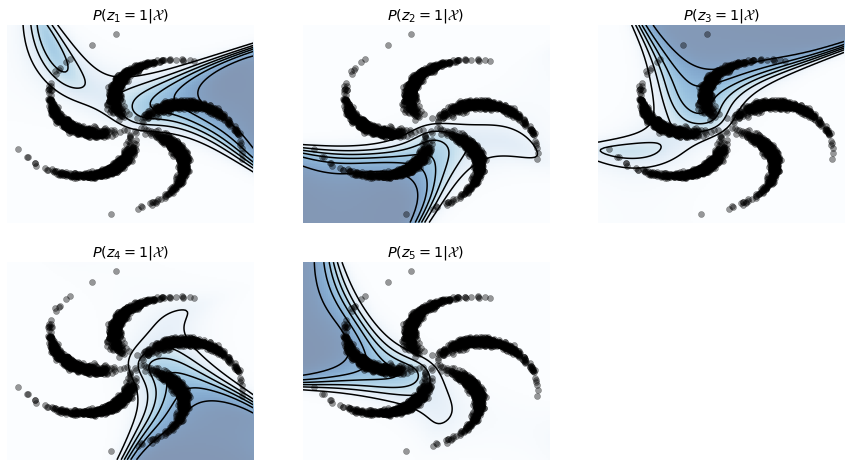

In [24]:
fig, ax = vis_utils.visualize_probas(DMAE_encoder, X, n_clusters, rows=2, cols=3, figsize=(15, 8))
ax[1, 2].axis("off")